In [202]:
import numpy as nu
import scanpy as sc
import pandas as pd
from scipy.sparse import csr_matrix

from matplotlib import pyplot as plt
from matplotlib import rcParams
%matplotlib inline

import leidenalg
import numpy.core.multiarray

In [2]:
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=200, facecolor='white')

/opt/conda/envs/spatialdata/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.10.4 anndata==0.11.1 umap==0.5.3 numpy==1.26.4 scipy==1.10.1 pandas==2.0.2 scikit-learn==1.2.2 statsmodels==0.14.0 igraph==0.10.4 pynndescent==0.5.10


In [36]:
adata_main = sc.read("/home/jovyan/ifbdata/spatial_cell_id/Kush/data/Clarins_concatenated_adata.h5ad")

/opt/conda/envs/spatialdata/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [160]:
adata = adata_main.copy()

/opt/conda/envs/spatialdata/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [161]:
adata

AnnData object with n_obs × n_vars = 783686 × 20116
    obs: 'Dataset', 'Age', 'Sex', 'Skin area', 'Ethnicity', 'Publication'

In [162]:
adata.var_names_make_unique() #makes the gene names unique by appending a number string to each duplicate index element

In [163]:
# Ribosomal genes and micochondrial genes are detected, and their percentage in each cell is generated and saved

adata.var['ribo'] = adata.var_names.str.startswith(("RpS","RpL"))
adata.var['mt'] = adata.var_names.str.startswith(("Mt", "MT")) #had to include "MT" for our case

sc.pp.calculate_qc_metrics(adata, qc_vars=['ribo', 'mt'], percent_top=None, log1p=False, inplace=True)

normalizing counts per cell


/opt/conda/envs/spatialdata/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


    finished (0:00:03)


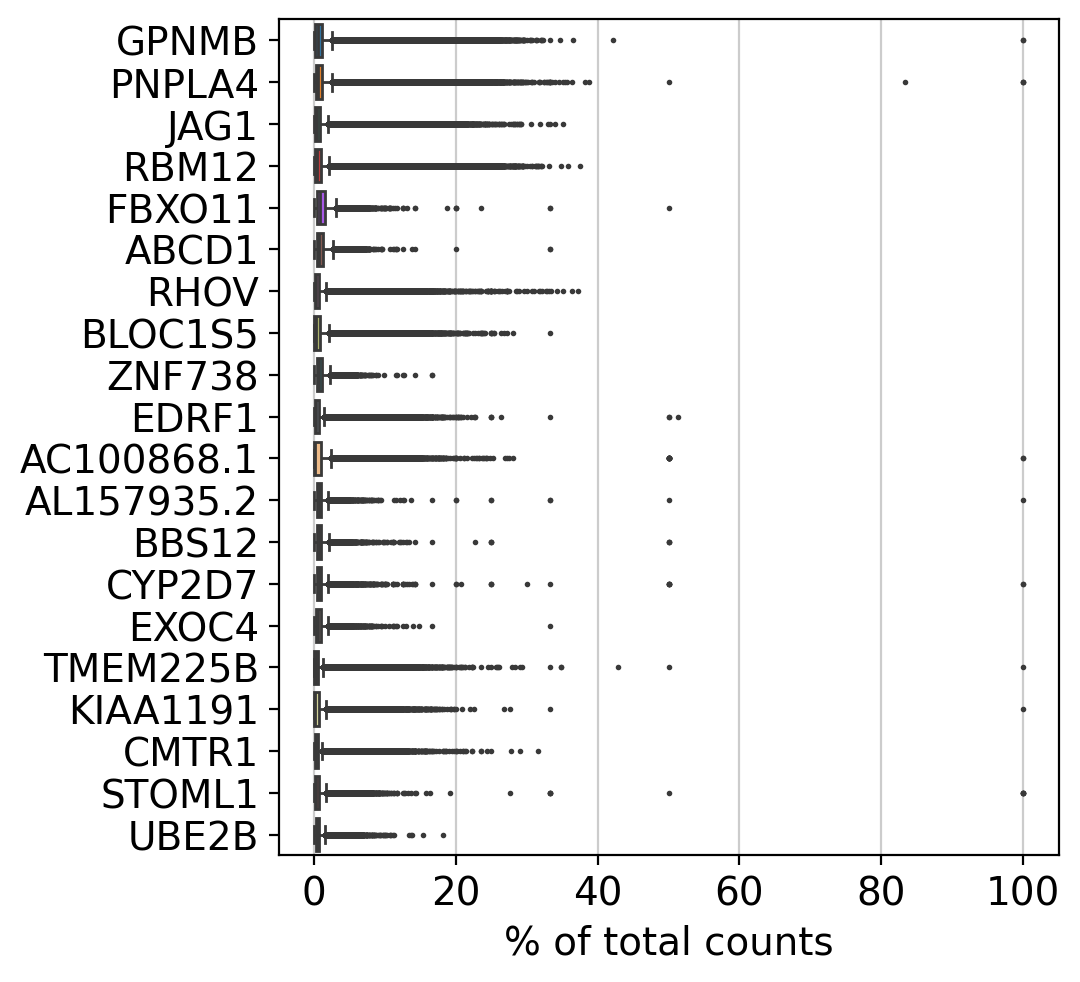

In [164]:
sc.settings.set_figure_params(dpi=100, facecolor='white')
sc.pl.highest_expr_genes(adata, n_top=20)

In [165]:
print(adata.obs['Publication'].value_counts())

Publication
multiscale_spacial_mapping               277891
eyelids_full_skin                        233078
multiscale_spacial_mapping_2             187794
sun_protected_human_skin_inguinoiliac     31302
atopic_dermatitis_healthy                 27096
Dermal_sheath_outer_forearm               24589
photoaging_extensor_side                   1936
Name: count, dtype: int64


In [166]:
print(adata.obs.index.is_unique)  #False = which means the index (which are cells) have duplicates 

False


In [167]:
print(adata.obs.index[adata.obs.index.duplicated()]) #524412 duplicate cells (66.9%) 

Index(['AAGCAGTGGTATCAAC', 'GATCATGTCGGCTTCT', 'CTCATGCAGCCGCACT',
       'GAGTTACCAAACACCT', 'TCCCACACAAGCCCAC', 'TAAGTCGCAAAGAGTT',
       'GCAGTGGTATCAACGC', 'TGTCCCACACAATGAA', 'ATGGGAGTCCTTATAC',
       'GCATCCTCTCCTATTA',
       ...
       'CGCCAAGTCCAAGCCG', 'ACGCCAGAGCTAGGCA', 'CGTAGGCAGCTAAGAT',
       'CACTCCACAAGACGTG', 'CGACTTCGTCGAATCT', 'TTGACTTGTTTAAGCC',
       'GCGCCAAGTACGAAAT', 'CAGCCGAGTTCCCTTG', 'TGTCCCAGTTATTCTC',
       'GTAACGTTCTTTACAC'],
      dtype='object', length=524412)


In [168]:
adata.obs['cell_names'] = adata.obs.index #making the cells column to a new column instead of index
adata.obs.reset_index(drop=True, inplace=True) #and re indexing to unique numbering from 0 
# adata.obs.index = adata.obs.index.astype(str) #converting the index to string for the "_normalize_index" error in filteration step
# to not loose the info about cells and still be able to use index for grouping

In [169]:
adata.obs

,Dataset,Age,Sex,Skin area,Ethnicity,Publication,n_genes_by_counts,total_counts,total_counts_ribo,pct_counts_ribo,total_counts_mt,pct_counts_mt,cell_names
0,WS_SKN_KCL9369629_S1,80,Male,forehead,not known,multiscale_spacial_mapping,2492,8085.142578,0.0,0.0,60.833336,0.752409,GAACACTTCATTGCGA
1,WS_SKN_KCL9369629_S1,80,Male,forehead,not known,multiscale_spacial_mapping,3143,10122.234375,0.0,0.0,46.333332,0.457738,TCTCACGTCCGCACTT
2,WS_SKN_KCL9369629_S1,80,Male,forehead,not known,multiscale_spacial_mapping,2818,7325.214844,0.0,0.0,38.833336,0.530132,CTCCAACTCTCCTACG
3,WS_SKN_KCL9369629_S1,80,Male,forehead,not known,multiscale_spacial_mapping,2762,8198.296875,0.0,0.0,29.000000,0.353732,AGATGAAAGACTCGAG
4,WS_SKN_KCL9369629_S1,80,Male,forehead,not known,multiscale_spacial_mapping,3401,13108.109375,0.0,0.0,68.000000,0.518763,GCTACCTAGCAATAAC
...,...,...,...,...,...,...,...,...,...,...,...,...,...
783681,SRR15440585,74.25,Female,outer forearm,Caucasian,Dermal_sheath_outer_forearm,283,420.452362,0.0,0.0,1.000000,0.237839,ACTCTAATCGGTTAAC
783682,SRR15440585,74.25,Female,outer forearm,Caucasian,Dermal_sheath_outer_forearm,44,51.250000,0.0,0.0,0.000000,0.000000,AGACGTTTCCGTACAA
783683,SRR15440585,74.25,Female,outer forearm,Caucasian,Dermal_sheath_outer_forearm,50,53.833332,0.0,0.0,0.000000,0.000000,CCGGGATCAGCAGTTT
783684,SRR15440585,74.25,Female,outer forearm,Caucasian,Dermal_sheath_outer_forearm,49,58.000000,0.0,0.0,0.000000,0.000000,CGGTTAACAAGTCTAC


In [170]:
print(adata.obs.index.is_unique) #now that the indexes are true

True


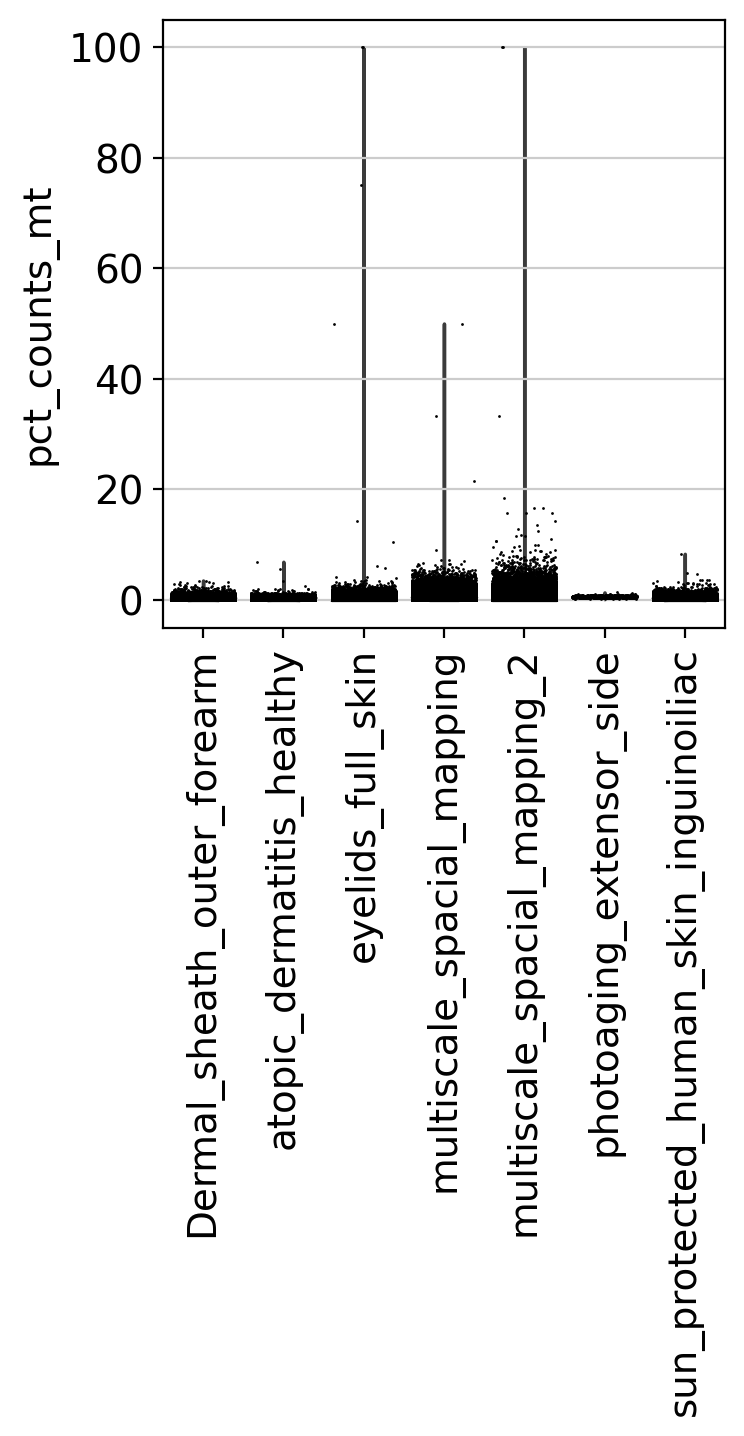

In [171]:
sc.settings.set_figure_params(dpi = 100, facecolor='white')
sc.pl.violin(adata, ['pct_counts_mt'], jitter=0.4, groupby = 'Publication', rotation= 90)
# percentage of mitochondrial gene expression 

In [172]:
adata.obs['pct_counts_mt'].max() #just to check if the percentange column was divided by 100 or not, it isn't

100.0

In [173]:
# filter the cells expressing more than 20% of mitochondrial genes (852 removed)
adata = adata[adata.obs['pct_counts_mt'] < 20, :]

print("Remaining cells %d" %adata.n_obs)

Remaining cells 782834


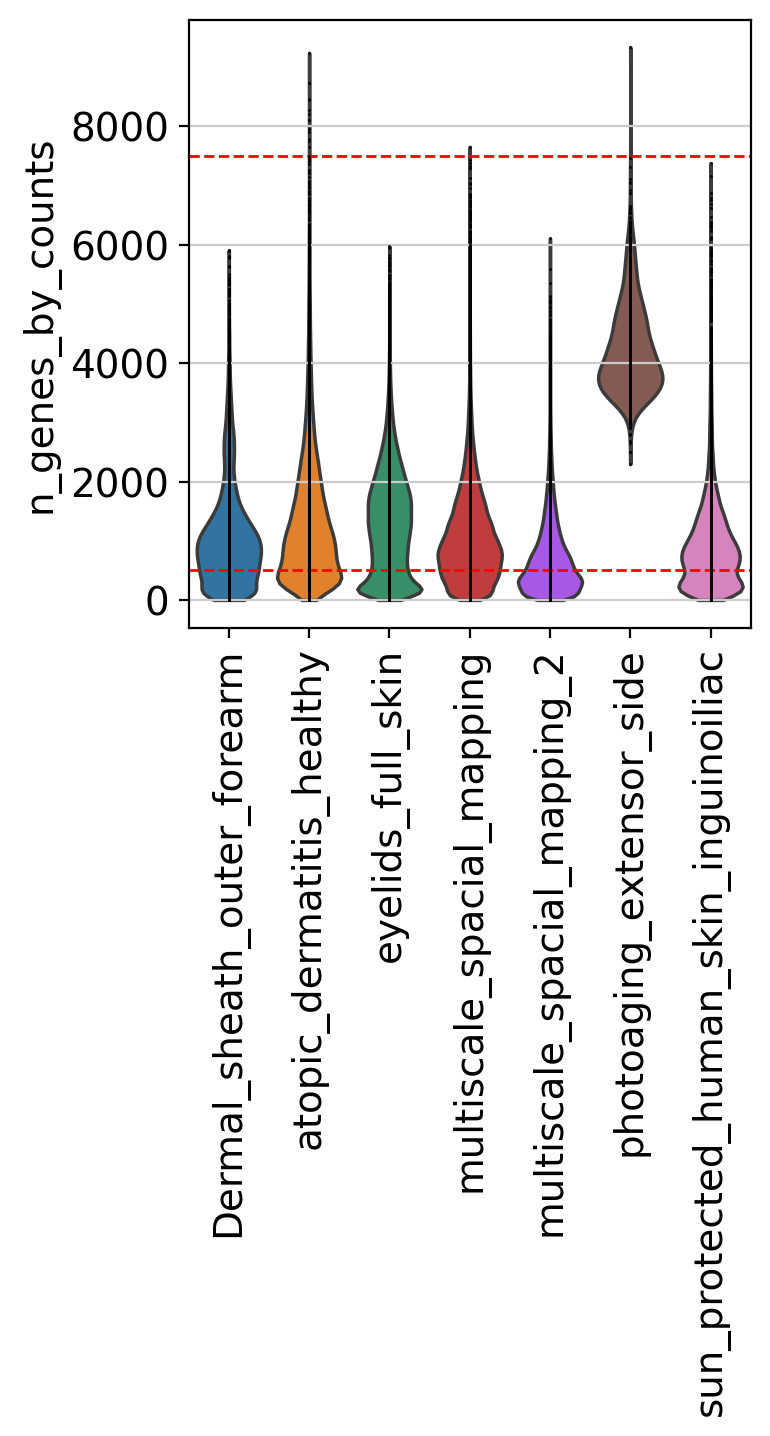

In [174]:
# visualizing the number of genes and the total counts for each publication
sc.settings.set_figure_params(dpi = 100, facecolor='white')
sc.pl.violin(adata, ['n_genes_by_counts'], jitter=0, groupby = 'Publication', rotation= 90, show=False) 
plt.axhline(y=500, color='red', linestyle='--', linewidth=1)
plt.axhline(y=7500, color='red', linestyle='--', linewidth=1)

plt.show()
# red lines show the filtering criteria set
# n_genes_by_counts = how many genes are being actively transcribed in the cell (number of genes that have non-zero expression)

#  show=False will not plot the voilin and plt.axhline will add the horizontal lines and then plt.show will print with lines

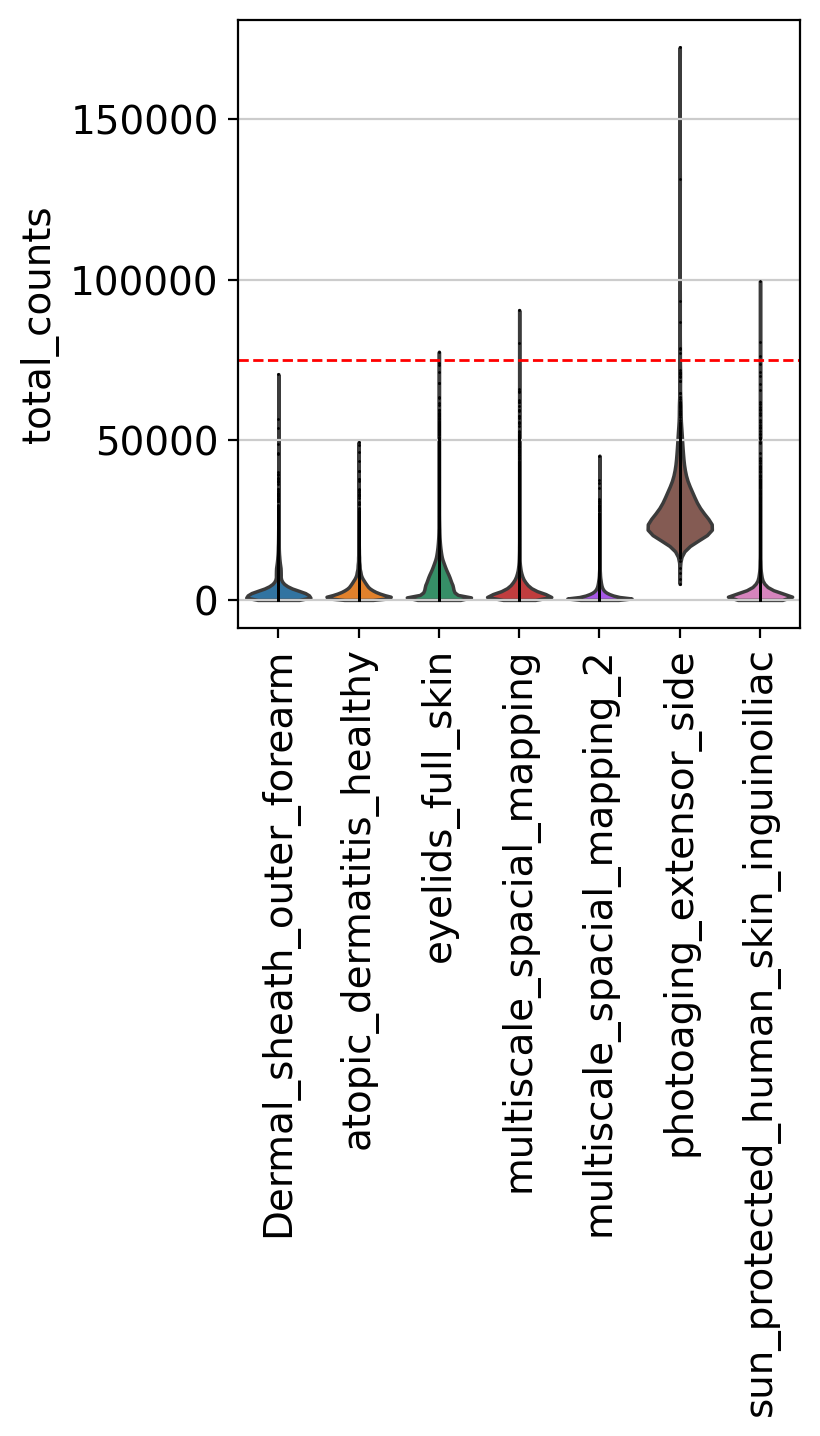

In [175]:
sc.settings.set_figure_params(dpi = 100, facecolor='white')
sc.pl.violin(adata, ['total_counts'], jitter=0, groupby = 'Publication', rotation= 90, show=False)
plt.axhline(y=75000, color='red', linestyle='--', linewidth=1)

plt.show()

# red lines show the filtering criteria set
# total_counts = total number of RNA counts (or reads) for a particular cell (sum of all gene expression counts for that cell)

In [176]:
adata.obs

,Dataset,Age,Sex,Skin area,Ethnicity,Publication,n_genes_by_counts,total_counts,total_counts_ribo,pct_counts_ribo,total_counts_mt,pct_counts_mt,cell_names
0,WS_SKN_KCL9369629_S1,80,Male,forehead,not known,multiscale_spacial_mapping,2492,8085.142578,0.0,0.0,60.833336,0.752409,GAACACTTCATTGCGA
1,WS_SKN_KCL9369629_S1,80,Male,forehead,not known,multiscale_spacial_mapping,3143,10122.234375,0.0,0.0,46.333332,0.457738,TCTCACGTCCGCACTT
2,WS_SKN_KCL9369629_S1,80,Male,forehead,not known,multiscale_spacial_mapping,2818,7325.214844,0.0,0.0,38.833336,0.530132,CTCCAACTCTCCTACG
3,WS_SKN_KCL9369629_S1,80,Male,forehead,not known,multiscale_spacial_mapping,2762,8198.296875,0.0,0.0,29.000000,0.353732,AGATGAAAGACTCGAG
4,WS_SKN_KCL9369629_S1,80,Male,forehead,not known,multiscale_spacial_mapping,3401,13108.109375,0.0,0.0,68.000000,0.518763,GCTACCTAGCAATAAC
...,...,...,...,...,...,...,...,...,...,...,...,...,...
783681,SRR15440585,74.25,Female,outer forearm,Caucasian,Dermal_sheath_outer_forearm,283,420.452362,0.0,0.0,1.000000,0.237839,ACTCTAATCGGTTAAC
783682,SRR15440585,74.25,Female,outer forearm,Caucasian,Dermal_sheath_outer_forearm,44,51.250000,0.0,0.0,0.000000,0.000000,AGACGTTTCCGTACAA
783683,SRR15440585,74.25,Female,outer forearm,Caucasian,Dermal_sheath_outer_forearm,50,53.833332,0.0,0.0,0.000000,0.000000,CCGGGATCAGCAGTTT
783684,SRR15440585,74.25,Female,outer forearm,Caucasian,Dermal_sheath_outer_forearm,49,58.000000,0.0,0.0,0.000000,0.000000,CGGTTAACAAGTCTAC


In [177]:
adata.obs.reset_index(drop=True, inplace=True)

/opt/conda/envs/spatialdata/lib/python3.10/site-packages/pandas/core/frame.py:6216: ImplicitModificationWarning: Trying to modify index of attribute `.obs` of view, initializing view as actual.
  new_obj.index = new_index
/opt/conda/envs/spatialdata/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/opt/conda/envs/spatialdata/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [178]:
adata.obs

,Dataset,Age,Sex,Skin area,Ethnicity,Publication,n_genes_by_counts,total_counts,total_counts_ribo,pct_counts_ribo,total_counts_mt,pct_counts_mt,cell_names
0,WS_SKN_KCL9369629_S1,80,Male,forehead,not known,multiscale_spacial_mapping,2492,8085.142578,0.0,0.0,60.833336,0.752409,GAACACTTCATTGCGA
1,WS_SKN_KCL9369629_S1,80,Male,forehead,not known,multiscale_spacial_mapping,3143,10122.234375,0.0,0.0,46.333332,0.457738,TCTCACGTCCGCACTT
2,WS_SKN_KCL9369629_S1,80,Male,forehead,not known,multiscale_spacial_mapping,2818,7325.214844,0.0,0.0,38.833336,0.530132,CTCCAACTCTCCTACG
3,WS_SKN_KCL9369629_S1,80,Male,forehead,not known,multiscale_spacial_mapping,2762,8198.296875,0.0,0.0,29.000000,0.353732,AGATGAAAGACTCGAG
4,WS_SKN_KCL9369629_S1,80,Male,forehead,not known,multiscale_spacial_mapping,3401,13108.109375,0.0,0.0,68.000000,0.518763,GCTACCTAGCAATAAC
...,...,...,...,...,...,...,...,...,...,...,...,...,...
782829,SRR15440585,74.25,Female,outer forearm,Caucasian,Dermal_sheath_outer_forearm,283,420.452362,0.0,0.0,1.000000,0.237839,ACTCTAATCGGTTAAC
782830,SRR15440585,74.25,Female,outer forearm,Caucasian,Dermal_sheath_outer_forearm,44,51.250000,0.0,0.0,0.000000,0.000000,AGACGTTTCCGTACAA
782831,SRR15440585,74.25,Female,outer forearm,Caucasian,Dermal_sheath_outer_forearm,50,53.833332,0.0,0.0,0.000000,0.000000,CCGGGATCAGCAGTTT
782832,SRR15440585,74.25,Female,outer forearm,Caucasian,Dermal_sheath_outer_forearm,49,58.000000,0.0,0.0,0.000000,0.000000,CGGTTAACAAGTCTAC


In [179]:
adata = adata[adata.obs['n_genes_by_counts'] > 500, :]
print("Remaining cells %d" %adata.n_obs)

Remaining cells 549915


In [180]:
adata = adata[adata.obs['n_genes_by_counts'] < 7500, :]
print("Remaining cells %d" %adata.n_obs)

Remaining cells 549898


In [181]:
adata = adata[adata.obs['total_counts'] < 75000, :]
print("Remaining cells %d" %adata.n_obs)

Remaining cells 549886


In [182]:
adata.obs.reset_index(drop=True, inplace=True)

/opt/conda/envs/spatialdata/lib/python3.10/site-packages/pandas/core/frame.py:6216: ImplicitModificationWarning: Trying to modify index of attribute `.obs` of view, initializing view as actual.
  new_obj.index = new_index
/opt/conda/envs/spatialdata/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [183]:
adata.obs

,Dataset,Age,Sex,Skin area,Ethnicity,Publication,n_genes_by_counts,total_counts,total_counts_ribo,pct_counts_ribo,total_counts_mt,pct_counts_mt,cell_names
0,WS_SKN_KCL9369629_S1,80,Male,forehead,not known,multiscale_spacial_mapping,2492,8085.142578,0.0,0.0,60.833336,0.752409,GAACACTTCATTGCGA
1,WS_SKN_KCL9369629_S1,80,Male,forehead,not known,multiscale_spacial_mapping,3143,10122.234375,0.0,0.0,46.333332,0.457738,TCTCACGTCCGCACTT
2,WS_SKN_KCL9369629_S1,80,Male,forehead,not known,multiscale_spacial_mapping,2818,7325.214844,0.0,0.0,38.833336,0.530132,CTCCAACTCTCCTACG
3,WS_SKN_KCL9369629_S1,80,Male,forehead,not known,multiscale_spacial_mapping,2762,8198.296875,0.0,0.0,29.000000,0.353732,AGATGAAAGACTCGAG
4,WS_SKN_KCL9369629_S1,80,Male,forehead,not known,multiscale_spacial_mapping,3401,13108.109375,0.0,0.0,68.000000,0.518763,GCTACCTAGCAATAAC
...,...,...,...,...,...,...,...,...,...,...,...,...,...
549881,SRR15440585,74.25,Female,outer forearm,Caucasian,Dermal_sheath_outer_forearm,620,1358.785645,0.0,0.0,3.333333,0.245317,CAGAATCTCGTGTAGT
549882,SRR15440585,74.25,Female,outer forearm,Caucasian,Dermal_sheath_outer_forearm,520,640.000000,0.0,0.0,3.000000,0.468750,CGATCGGCCGATCTCG
549883,SRR15440585,74.25,Female,outer forearm,Caucasian,Dermal_sheath_outer_forearm,634,1134.999756,0.0,0.0,5.500000,0.484582,AGCGTCGAGTCTCAAC
549884,SRR15440585,74.25,Female,outer forearm,Caucasian,Dermal_sheath_outer_forearm,610,959.931885,0.0,0.0,3.000000,0.312522,GCGACCATCGTGTAGT


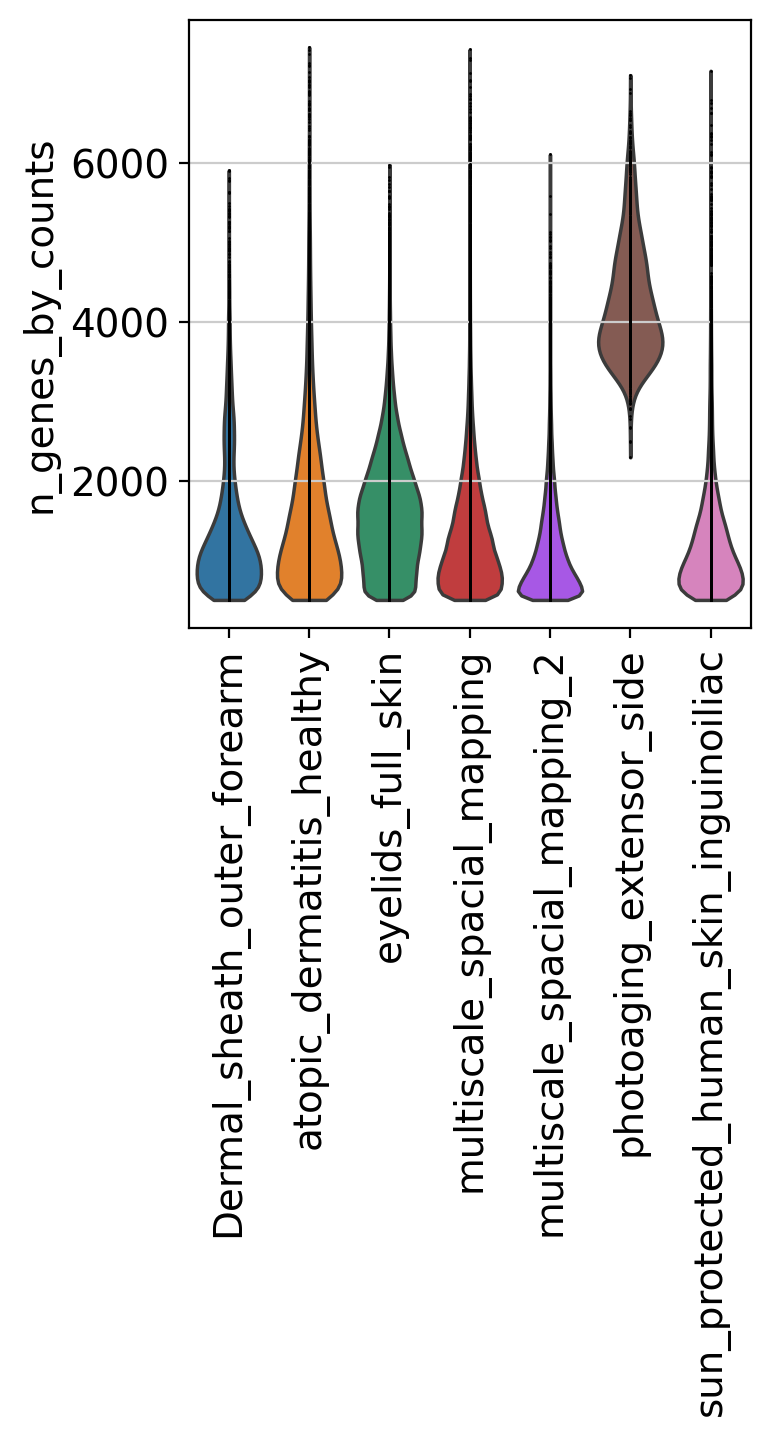

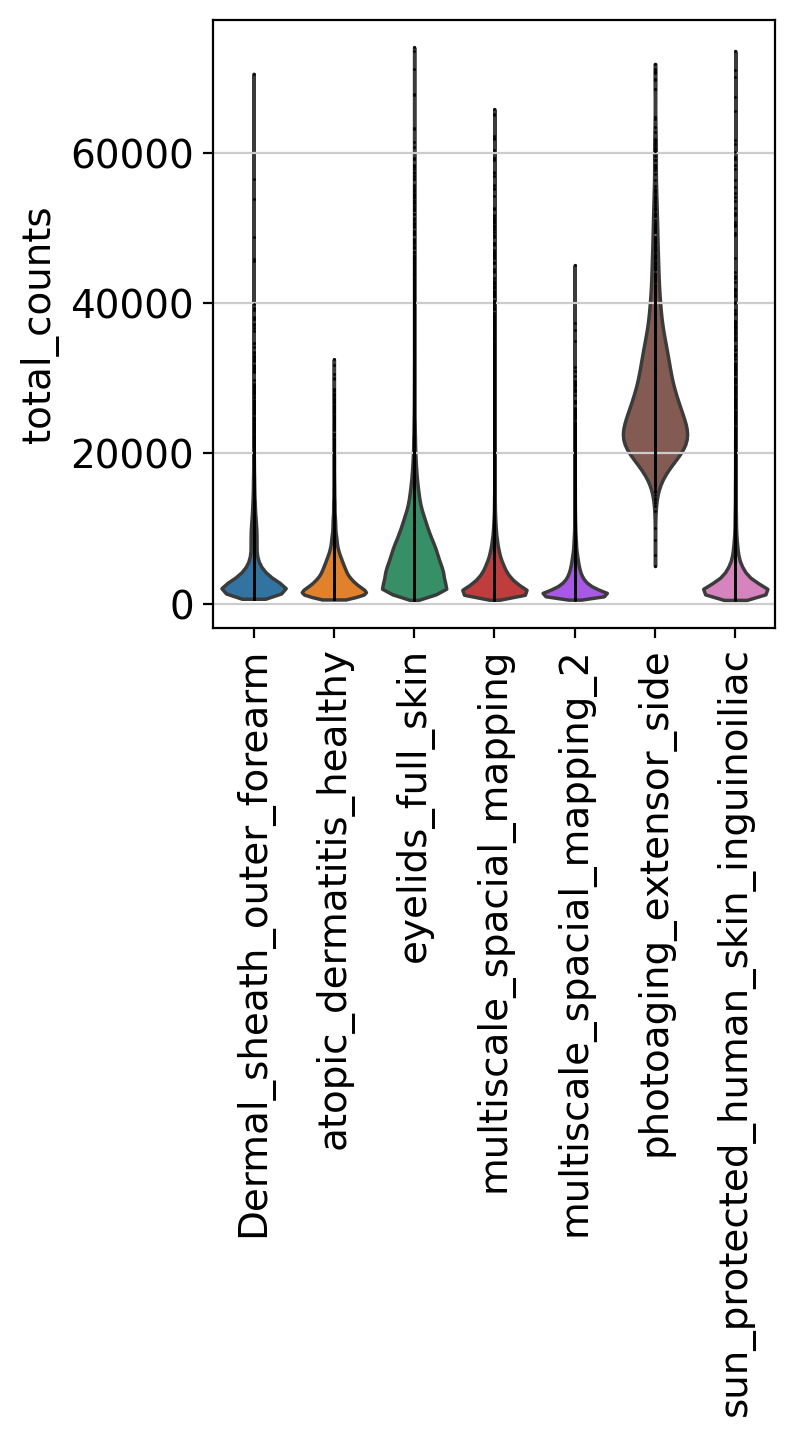

In [184]:
# now after the filteration
# setting the jitter to 0 to visualize violins due to high number of genes
sc.settings.set_figure_params(dpi = 100, facecolor='white')
sc.pl.violin(adata, ['n_genes_by_counts'], jitter=0, groupby = 'Publication', rotation= 90)
sc.pl.violin(adata, ['total_counts'], jitter=0, groupby = 'Publication', rotation= 90)

In [186]:
# setting filter of minimum genes expressed = 200
sc.pp.filter_cells(adata, min_genes=200)
print("Remaining cells %d" %adata.n_obs) # another way of printing

Remaining cells 549886


In [187]:
# setting filter of gene minimum expressed in 3 cells to be included
sc.pp.filter_genes(adata, min_cells=3)
print(f"Remaining genes: {adata.n_vars}") 

filtered out 915 genes that are detected in less than 3 cells
Remaining genes: 19201


In [188]:
# reseting index after all filteration
adata.obs.reset_index(drop=True, inplace=True)

In [189]:
adata2 = adata.copy() #this is the filtered adata

/opt/conda/envs/spatialdata/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [190]:
adata2

AnnData object with n_obs × n_vars = 549886 × 19201
    obs: 'Dataset', 'Age', 'Sex', 'Skin area', 'Ethnicity', 'Publication', 'n_genes_by_counts', 'total_counts', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_mt', 'pct_counts_mt', 'cell_names', 'n_genes'
    var: 'ribo', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'Publication_colors'

In [191]:
# exporting the fitered adata for easy further access
adata2.write("/home/jovyan/ifbdata/spatial_cell_id/Kush/Scanpy_analysis/adata_filtered.h5ad")

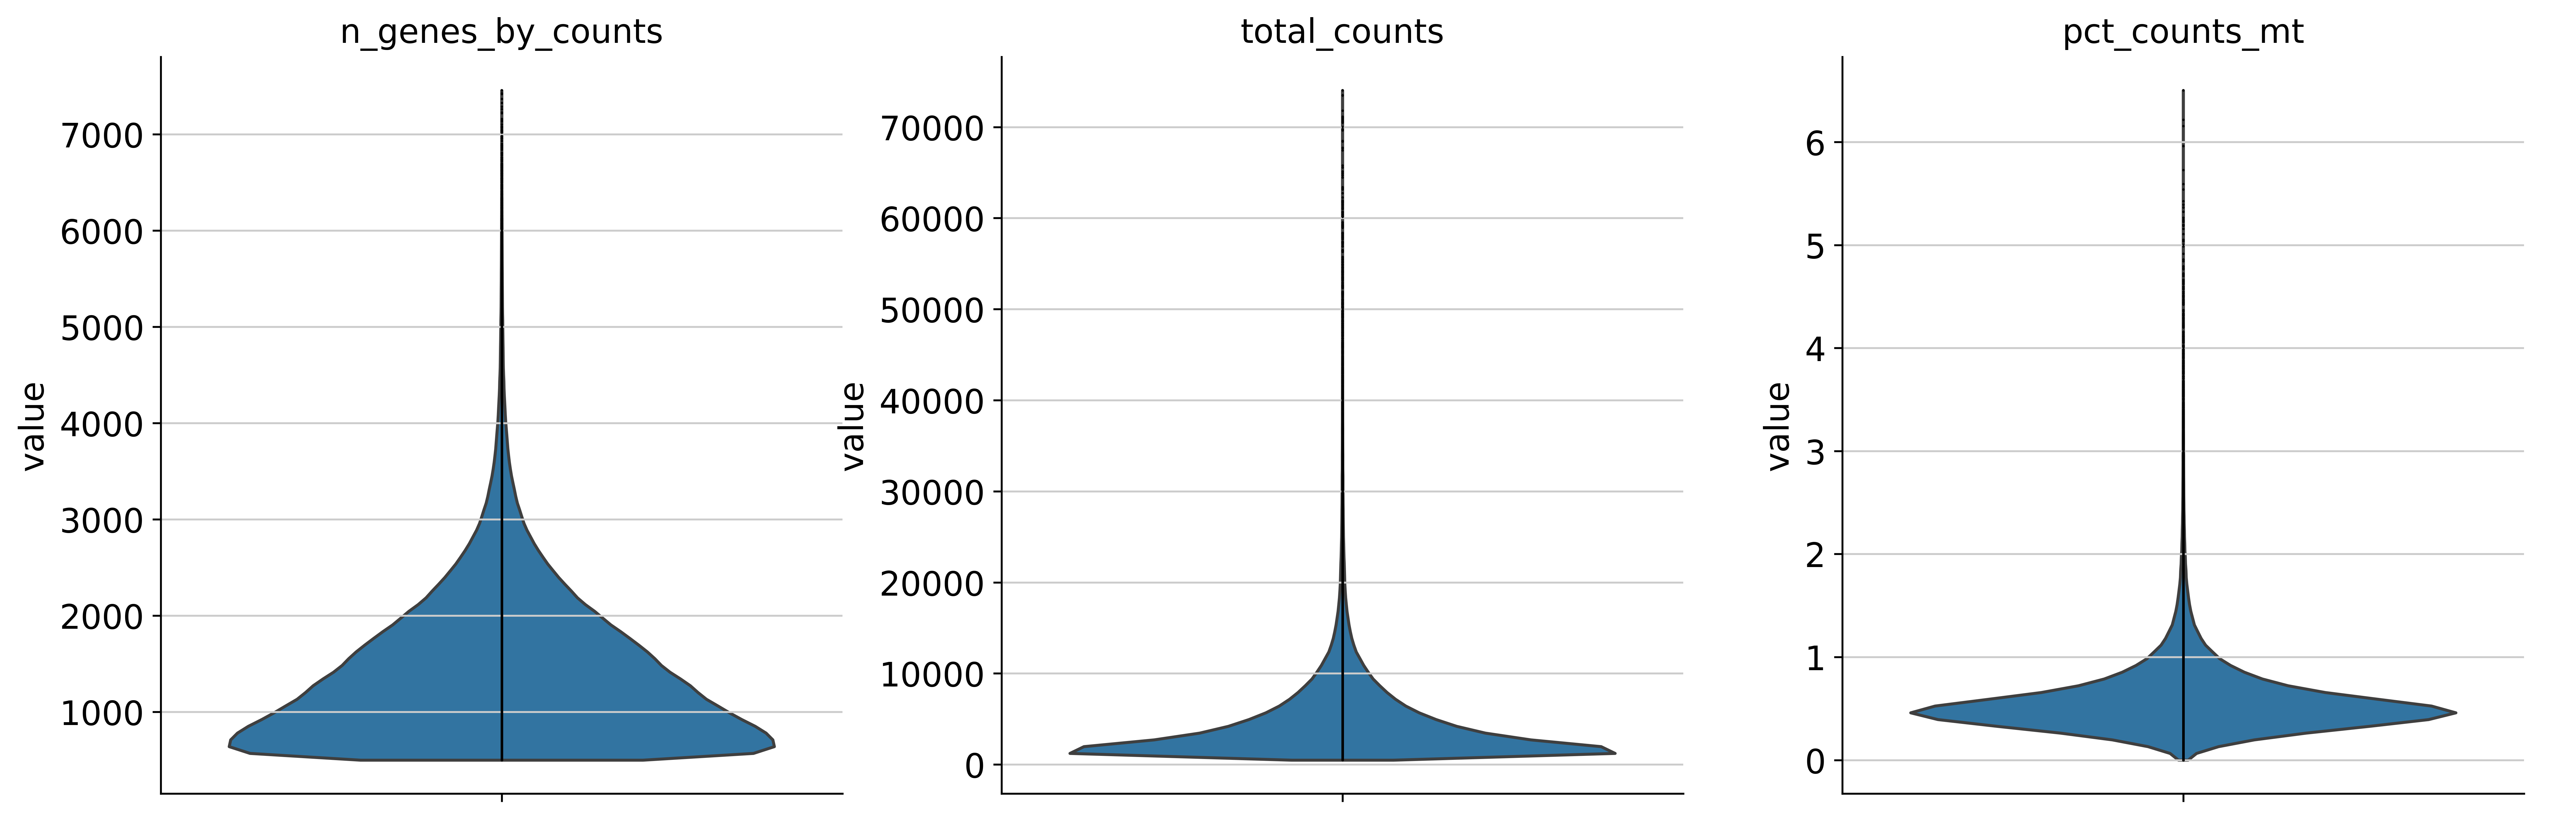

In [192]:
sc.settings.set_figure_params(dpi = 300, facecolor='white')
sc.pl.violin(adata2, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0, multi_panel=True) #need to adjust jitter for non-cluttered plots.

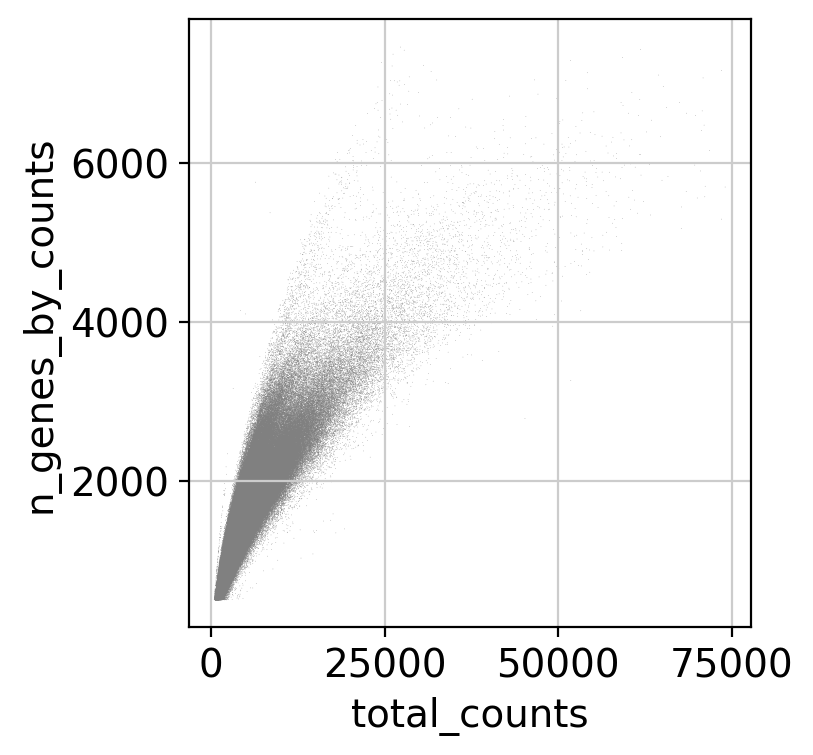

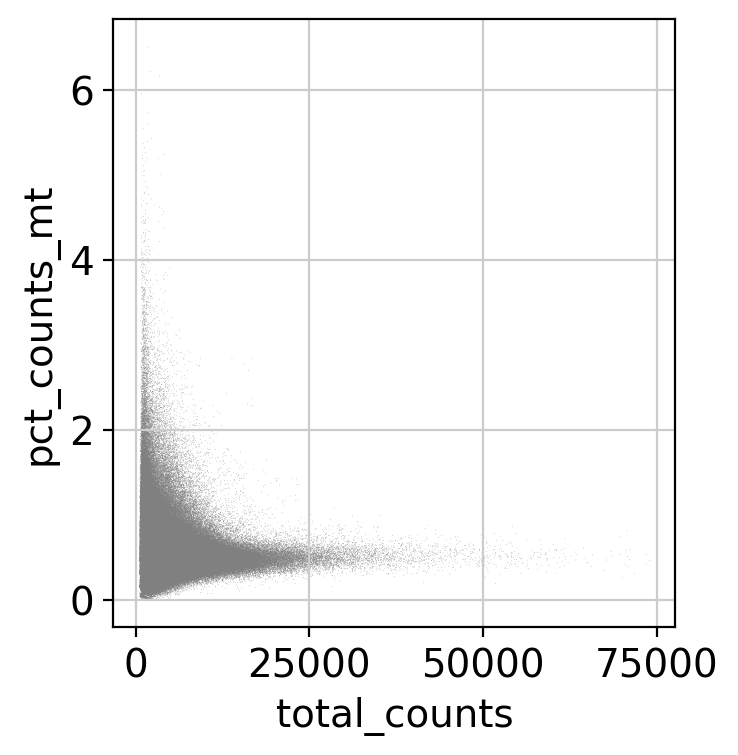

In [193]:
sc.settings.set_figure_params(dpi = 100, facecolor='white')
sc.pl.scatter(adata2, x='total_counts', y='n_genes_by_counts')
sc.pl.scatter(adata2, x="total_counts", y="pct_counts_mt")

In [194]:
# normalization to total genes per cell = 10,000 or 1e4
# accounts for sequencing depth 
sc.pp.normalize_total(adata2, target_sum=1e4)

normalizing counts per cell
    finished (0:00:02)


In [195]:
# log transformation 
# accounts for skewness between high and low expression and makes data suitable for dimensionality reduction
sc.pp.log1p(adata2)

In [197]:
# with all default values (min_mean=0.0125, max_mean=3, min_disp=0.5)
# adds 4 columns to adata.var
# highly expressed genes have higher variance 
sc.pp.highly_variable_genes(adata2)

extracting highly variable genes
    finished (0:00:07)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


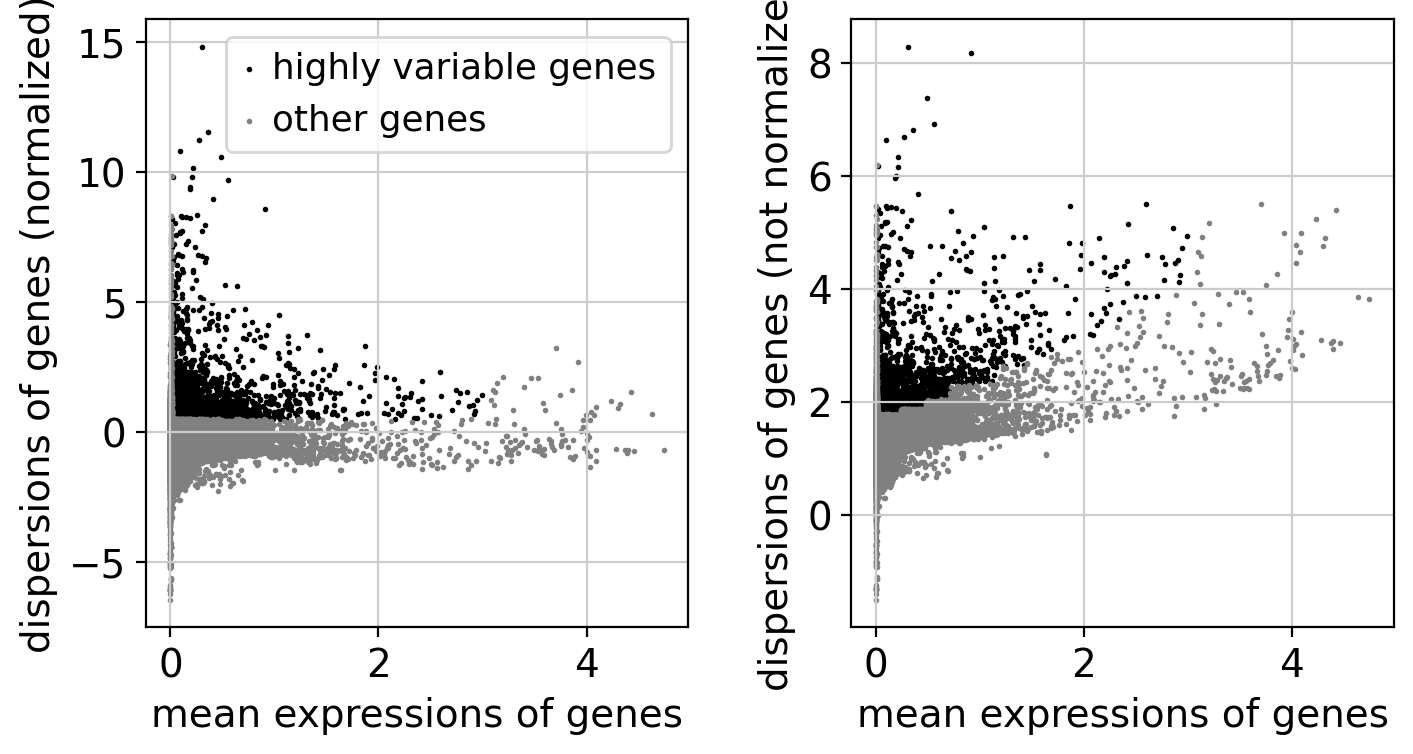

In [200]:
sc.pl.highly_variable_genes(adata2)

In [201]:
# storing the current unscaled data in the raw attribute for further comparison
adata2.raw = adata2
#and can access by calling:
# adata_from_raw = adata.raw.to_adata()

In [203]:
# Removing/adjusting unwanted variance
# removing/regressing out the effect of total counts per cell and perc of mt genes expressed.
# focus on biological variation rather than technical noise
sc.pp.regress_out(adata2, ["total_counts", "pct_counts_mt"])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (4:25:58)


In [204]:
#scaling each gene to unit variance and trimming off values exceeding standard daviation 10.
sc.pp.scale(adata2, max_value=10)